# Bayes

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm, tnrange
from math import log

## Preparing data

In [2]:
def get_data_from_file(filename):
    legit = 0
    if "legit" in filename:
        legit = 1
    
    with open(filename, "r") as file:
        subject_words = file.readline()[9:-1].split()
        file.readline()
        message_words = file.readline()[:-1].split()
        
    return list(map(int, subject_words)), list(map(int, message_words)), legit

In [3]:
def get_ngrams_from_lists(subject_words, message_words, n):
    subject_ngrams = [tuple(subject_words[j:j+n]) for j in range(len(subject_words)-n+1)]
    message_ngrams = [tuple(message_words[j:j+n]) for j in range(len(message_words)-n+1)]
    
    if not subject_ngrams:
        return message_ngrams
    
    return subject_ngrams + message_ngrams

In [4]:
def get_vector_from_ngrams(letter, ndict):
    vec = np.zeros(len(ndict))
    
    for ngram in letter:
        vec[ndict[ngram]] = 1
    
    return vec

In [5]:
def get_prepared_data_from_dir(n, data_dirname='messages/'):
    X = []
    y = []
    X_ngrams = []
    all_ngrams = []

    ngram_dict = {}

    for dirname in os.listdir(data_dirname):
        filenames = os.listdir(data_dirname + dirname)
        full_filenames = [data_dirname + dirname + '/' + filename for filename in filenames]
    
        part_x = []
        part_y = []
        for name in full_filenames:
            subject_words, message_words, legit = get_data_from_file(name)
            cur_ngrams = get_ngrams_from_lists(subject_words, message_words, n)
            part_x.append(cur_ngrams)
            part_y.append(legit)
            all_ngrams += cur_ngrams
    
        X_ngrams.append(part_x)
        y.append(part_y)
        
    all_ngrams = list(set(all_ngrams))
    
    for i in range(len(all_ngrams)):
        ngram_dict[all_ngrams[i]] = i
    
    for part in X_ngrams:
        vpart = []
        for letter in part:
            vec = get_vector_from_ngrams(letter, ngram_dict)
            vpart.append(vec)
        X.append(vpart)
        
    return X, y, ngram_dict

## Bayes clf

In [6]:
def get_classes_a_priori_proba(labels):
    legit = np.count_nonzero(labels)
    return legit/len(labels), (len(labels)-legit)/len(labels)

In [7]:
def get_laplas_proba(wcount, all_count, alpha):
    return (wcount + alpha)/(all_count + alpha*2)

In [8]:
def get_all_words_cond_proba(X, y, ndict, alpha):
    ndata = len(X)
    
    legit = X[y==1]
    spam = X[y==0]
    
    vlegit = np.zeros(len(ndict))
    vspam = np.zeros(len(ndict))
    
    for ngram in ndict:
        flegit = list(filter(lambda x: x[ndict[ngram]], legit))
        fspam = list(filter(lambda x: x[ndict[ngram]], spam))
        vlegit[ndict[ngram]] = get_laplas_proba(len(flegit), len(legit), alpha)
        vspam[ndict[ngram]] = get_laplas_proba(len(fspam), len(spam), alpha)
    
    return vlegit, vspam

In [9]:
def get_letter_proba(vletter, apri, vproba, lambda_):
    lproba = [vproba[i] if vletter[i] else 1-vproba[i] for i in range(len(vletter))]
    sum_cond_proba = sum(list(map(log, lproba)))
    
    return log(lambda_ * apri) + sum_cond_proba

In [10]:
def get_letter_class(vletter, apri_legit, apri_spam, vlegit, vspam, lambda_legit, lambda_spam):
    legit_proba = get_letter_proba(vletter, apri_legit, vlegit, lambda_legit)
    spam_proba = get_letter_proba(vletter, apri_spam, vspam, lambda_spam)
    
    if (legit_proba > spam_proba):
        return 1

    return 0

## Cross-validation and finding hyper-params

### Evaluation

In [11]:
def get_accuracy_and_legit_neg(y_actual, y_pred):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    
    for (a, p) in zip(y_actual, y_pred):
        if a == p:
            if p == 1:
                tp += 1
            else:
                tn += 1
        else:
            if p == 1:
                fp += 1
            else:
                fn += 1
                
    accuracy = (tp + tn) / (tp + fp + tn + fn) 
    
    return accuracy, fn, tp/(tp+fn), fp/(fp+tn)

### Splits

In [12]:
def get_train_test_data_and_dict(n):
    X, y, ndict = get_prepared_data_from_dir(n)
    train_x = []
    train_y = []
    test_x = []
    test_y = []
    
    for i in range(10):
        cur_train_x = np.delete(X, i, 0)
        cur_train_y = np.delete(y, i, 0)
        cur_test_x = X[:][i]
        cur_test_y = y[:][i]
        train_x.append(np.concatenate(cur_train_x))
        train_y.append(np.concatenate(cur_train_y))
        test_x.append(cur_test_x)
        test_y.append(cur_test_y)
        
    return train_x, train_y, test_x, test_y, ndict

### Params

In [13]:
ns = [1]
alphas = [0.0001, 0.001]
lambdas_legit = [1, 10000]
lambda_spam = 1

### Clf with finding best params

In [17]:
best_acc = 0
min_ln = 100000
best_params = []
best_roc = []
legit_neg = []
accs = []

for n in ns:
    for alpha in alphas:
        for ll in lambdas_legit:
            accs = []
            legit_neg = []
            tprs = []
            fprs = []
            train_x, train_y, test_x, test_y, ndict = get_train_test_data_and_dict(n)
            for i in range(10):
                vlegit, vspam = get_all_words_cond_proba(train_x[i], train_y[i], ndict, alpha)
                apri_legit, apri_spam = get_classes_a_priori_proba(train_y[i])
                test_pred_y = list(map(lambda x: get_letter_class(x, apri_legit, apri_spam, vlegit, vspam, ll, lambda_spam), test_x[i]))
                accuracy, ln, tpr, fpr = get_accuracy_and_legit_neg(test_y[i], test_pred_y)
                accs.append(accuracy)
                legit_neg.append(ln)
                tprs.append(tpr)
                fprs.append(fpr)
            average_acc = sum(accs)/len(accs)
            sum_ln = sum(legit_neg)
            print(str(average_acc) + " " + str(sum_ln))
            if sum_ln < min_ln or sum_ln == min_ln and average_acc > best_acc:
                best_acc = average_acc
                min_l = sum_ln
                best_params = [n, alpha, ll]
                best_roc = [tprs, fprs]

0.9669724770642203 6
0.956880733944954 4
0.9623853211009175 7
0.9559633027522935 5


## Graphs

In [18]:
print(best_params)

[1, 0.001, 10000]


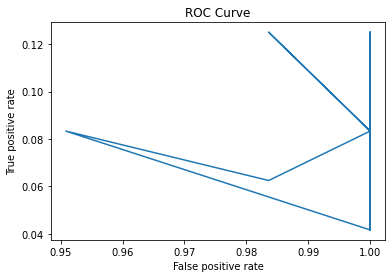

In [25]:
plt.title("ROC Curve")
plt.plot(best_roc[0], best_roc[1])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show()

In [22]:
average_accs = []

for ll in lambdas_legit:
    accs = []
    train_x, train_y, test_x, test_y, ndict = get_train_test_data_and_dict(best_params[0])
    for i in range(10):
        vlegit, vspam = get_all_words_cond_proba(train_x[i], train_y[i], ndict, best_params[1])
        apri_legit, apri_spam = get_classes_a_priori_proba(train_y[i])
        test_pred_y = list(map(lambda x: get_letter_class(x, apri_legit, apri_spam, vlegit, vspam, ll, lambda_spam), test_x[i]))
        accuracy, ln, tpr, fpr = get_accuracy_and_legit_neg(test_y[i], test_pred_y)
        accs.append(accuracy)
    average_accs.append(sum(accs)/len(accs))

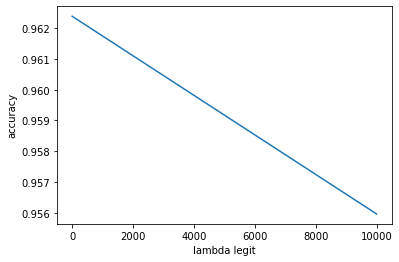

In [24]:
plt.plot(lambdas_legit, average_accs)
plt.xlabel("lambda legit")
plt.ylabel("accuracy")
plt.show()